In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alerce.core import Alerce
import sqlalchemy as sa

alerce_client = Alerce()

Se activa la conexión a internet usando las credenciales publicas proporcionadas por ALeRCE para usar su API.

In [2]:
import requests

credentials_file = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
params = requests.get(credentials_file).json()['params']
engine = sa.create_engine("postgresql+psycopg2://" + params["user"] \
                          + ":" + params["password"] + "@" + params["host"] \
                          + "/" + params["dbname"])
conn = engine.connect()

Se genera el `query` para obtener los datos de las supernovas tipo Ia classificadas por ALeRCE usando usando el LC classifier (Poner referencia). Seleccionando aquellas que tienen un valor de `probability` mayor a 0.5 y ordenandolas en orden decreciente de probabilidad.

In [3]:
query = """
SELECT
    *
FROM
    probability
WHERE
    classifier_name = 'lc_classifier'
    AND class_name = 'SNIa'
    AND probability >= 0.5
ORDER BY
    probability DESC
LIMIT 20
"""
alerce_dataframe = pd.read_sql_query(query, conn)
alerce_dataframe.head()


,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF20acobvxk,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.722000,1
1,ZTF22aalpfln,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.722000,1
2,ZTF21abuyhau,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.720000,1
3,ZTF21abywdxt,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.716564,1
4,ZTF22abqdmwt,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.714568,1


In [5]:
lightcurves = alerce_client.query_detections(oid=alerce_dataframe['oid'][0], format='pandas')
lightcurves.head()

KeyboardInterrupt: 

Obtenemos las curvas de luz de los primeros 10 objetos en `prob_dt`. Las agrupamos en un solo `DataFrame` para su análisis posterior.

Además seleccionamos solo las columnas que nos interesan para el análisis: `oid`, `mjd`, `magpsf`, `sigmapsf` y `fid`, donde:
- `oid`: Identificador único del objeto.
- `mjd`: Tiempo de la observación en días julianos modificados.
- `magpsf`: Magnitud aparente del objeto.
- `sigmapsf`: Incertidumbre en la magnitud aparente.
- `fid`: Filtro utilizado en la observación (1 para g, 2 para r, 3 para i).

In [6]:
lightcurves = []
num_lghtcurves = 10
for oid in alerce_dataframe['oid'].head(num_lghtcurves):
    lightcurve = alerce_client.query_detections(oid=oid, format='pandas')
    lightcurve['oid'] = oid
    lightcurves.append(lightcurve)
lightcurves = pd.concat(lightcurves, ignore_index=True)

# Filtramos solo los datos necesarios
lightcurves = lightcurves[['oid', 'mjd', 'magpsf', 'sigmapsf', 'fid']]

# Excluimos el filtro i (fid=3)
lightcurves = lightcurves[lightcurves['fid'] != 3] 

# Esto cierra la conexión a la base de datos
conn.close()

KeyboardInterrupt: 

In [ ]:
print(lightcurves.head())
print(lightcurves.columns, lightcurves.shape)
print(lightcurves.dtypes)
print(lightcurves.describe())

            oid           mjd     magpsf  sigmapsf  fid
0  ZTF20acobvxk  59149.448125  19.810800  0.236357    1
1  ZTF20acobvxk  59151.272535  19.568500  0.277572    1
2  ZTF20acobvxk  59151.350405  19.385900  0.217224    2
3  ZTF20acobvxk  59152.264155  19.226200  0.222367    1
4  ZTF20acobvxk  59153.332118  18.783262  0.167610    2
Index(['oid', 'mjd', 'magpsf', 'sigmapsf', 'fid'], dtype='object') (270, 5)
oid          object
mjd         float64
magpsf      float64
sigmapsf    float64
fid           int64
dtype: object
                mjd      magpsf    sigmapsf         fid
count    270.000000  270.000000  270.000000  270.000000
mean   59584.358777   18.897519    0.120860    1.514815
std      315.999840    0.584636    0.060249    0.500709
min    59149.448125   17.689812    0.040877    1.000000
25%    59452.545692   18.465402    0.077202    1.000000
50%    59487.750804   18.812645    0.104724    2.000000
75%    59878.345799   19.229323    0.153220    2.000000
max    60237.153507   20.7

Ahora vamos a graficar 9 de las 10 curvas de luz de las supernovas tipo Ia obtenidas. Cada gráfica mostrará la magnitud aparente en función del tiempo (mjd) para cada objeto, diferenciando los puntos según el filtro utilizado ($g$, $r$).

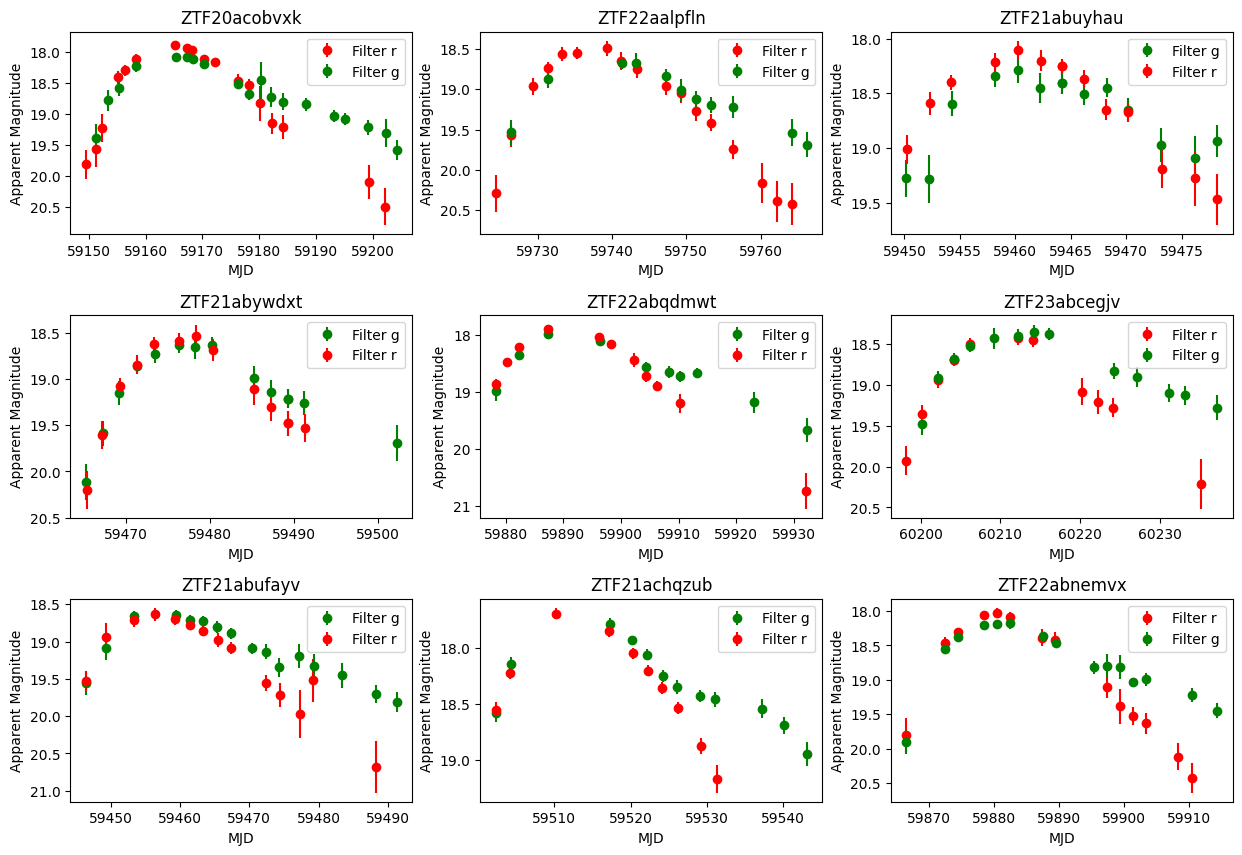

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
for i, oid in enumerate(lightcurves['oid'].unique()[:9]):
    lc = lightcurves[lightcurves['oid'] == oid]
    
    for fid in lc['fid'].unique():
        filter_name  = 'r' if fid == 1 else 'g'
        ax[i//3, i%3].errorbar(lc[lc['fid'] == fid]['mjd'], 
                               lc[lc['fid'] == fid]['magpsf'], 
                               lc[lc['fid'] == fid]['sigmapsf'], fmt='o',
                               label=f'Filter {filter_name}', color='r' if fid == 1 else 'g'
                            )
    ax[i//3, i%3].invert_yaxis()
    ax[i//3, i%3].set_title(f'{oid}')
    ax[i//3, i%3].set_xlabel('MJD')
    ax[i//3, i%3].set_ylabel('Apparent Magnitude')
    ax[i//3, i%3].legend()

Para ajustar cada curva de luz, utilizaremos un polinomio de grado 10. Este ajuste nos permitirá modelar la evolución de la magnitud aparente a lo largo del tiempo para cada supernova. Utilizaremos la función `numpy.polyfit` para realizar el ajuste polinomial y `numpy.polyval` para evaluar el polinomio ajustado en los puntos de tiempo correspondientes.

Además, calcularemos la derivada del polinomio ajustado utilizando `numpy.polyder`. Esto nos permitirá identificar los puntos críticos en la curva de luz, que corresponden a los máximos y mínimos locales. Encontraremos las raíces de la derivada utilizando `numpy.roots`, lo que nos dará los tiempos en los que ocurren estos puntos críticos. Finalmente, graficaremos las curvas de luz junto con los puntos críticos identificados para cada supernova

In [ ]:
ndeg = 4

metaoids, metafids, metamagmax, metamjdmax  = [], [], [], []

for oid, fid in lightcurves.groupby(['oid', 'fid']).groups.keys():
    lc = lightcurves[(lightcurves['oid'] == oid) & (lightcurves['fid'] == fid)]
    
    # Ajuste polinomial de grado n-th.
    coeffs     = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
    poly       = np.poly1d(coeffs)
    poly_deriv = np.polyder(poly) # Calcular la derivada del polinomio
    
    # Encontrar las raíces de la derivada
    mag_roots      = np.roots(poly_deriv)
    mjdmin, mjdmax = lc['mjd'].min(), lc['mjd'].max()
    peaks_mjd      = mag_roots[
        np.isreal(mag_roots) &
        (mag_roots.real >= mjdmin) &
        (mag_roots.real <= mjdmax)
    ].real
    
    # Evaluar el polinomio en los puntos críticos para encontrar los máximos y mínimos
    magmax = poly(peaks_mjd)
    
    # Encontrar el máximo (mínimo en magnitud)
    idxmax = np.argmin(magmax)
    
    # Obtener los valores correspondientes
    magmjd = peaks_mjd[idxmax]
    maxmag = magmax[idxmax] 
    
    metaoids.append(oid)
    metafids.append(fid)
    metamagmax.append(magmax)  

metadatos = {
    'oid': metaoids,
    'fid': metafids,
    'magmax_mjd': metamagmax
}

/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykernel_12131/718494202.py:9: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
/tmp/ipykerne

In [39]:
metadatos

lightcurves.attrs = metadatos

In [40]:
lightcurves.attrs

{'oid': ['ZTF20acobvxk',
  'ZTF20acobvxk',
  'ZTF20acoqlav',
  'ZTF20acoqlav',
  'ZTF21abufayv',
  'ZTF21abufayv',
  'ZTF21abuyhau',
  'ZTF21abuyhau',
  'ZTF21abywdxt',
  'ZTF21abywdxt',
  'ZTF21achqzub',
  'ZTF21achqzub',
  'ZTF22aalpfln',
  'ZTF22aalpfln',
  'ZTF22abnemvx',
  'ZTF22abnemvx',
  'ZTF22abqdmwt',
  'ZTF22abqdmwt',
  'ZTF23abcegjv',
  'ZTF23abcegjv'],
 'fid': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
 'magmax_mjd': [array([59200.2154236 +0.j, 59165.26601275+0.j]),
  array([59202.23755983+0.j, 59167.21881359+0.j]),
  array([59164.00854655+0.j]),
  array([59167.78553655+0.j]),
  array([59457.62426398+0.j]),
  array([59490.08935323+0.j, 59459.62529853+0.j]),
  array([59459.52767362+0.j]),
  array([59460.94378361+0.j]),
  array([59475.96489866+0.j]),
  array([59499.47772755+0.j, 59477.51920516+0.j]),
  array([59512.60070753+0.j]),
  array([59542.31059551+0.j, 59513.98275768+0.j]),
  array([59738.08803552+0.j]),
  array([59766.07968801+0.j, 59739.1249045 +0

In [26]:
ligtcurves.attrs

{}

/tmp/ipykernel_12131/3524665495.py:3: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(test_lightcurves['mjd'], test_lightcurves['magpsf'], deg=deg)


NameError: name 'real_roots' is not defined

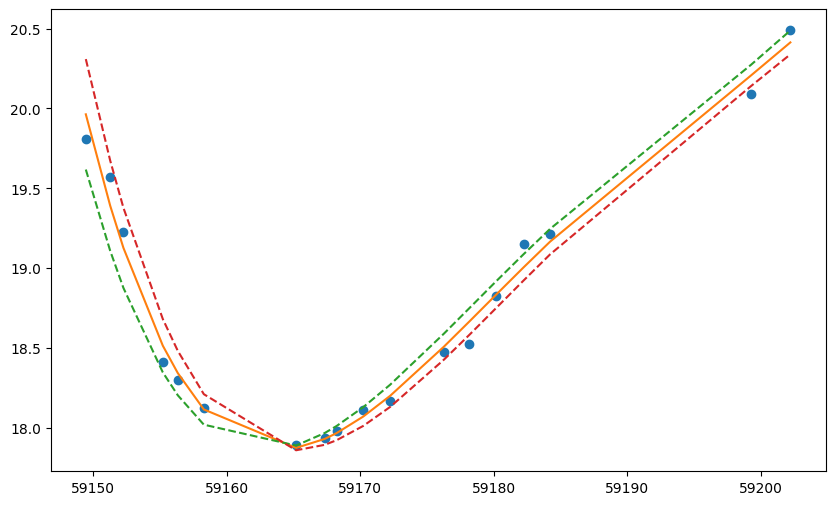

In [13]:
deg = 20
test_lightcurves = ligtcurves[ligtcurves['fid'] == 1]
coeffs = np.polyfit(test_lightcurves['mjd'], test_lightcurves['magpsf'], deg=deg)
coeffs
dcoeffs = np.polyder(coeffs)
dcoeffs

y  = np.polyval(coeffs, test_lightcurves['mjd'])
dy = np.polyval(dcoeffs, test_lightcurves['mjd'])
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_lightcurves['mjd'], test_lightcurves['magpsf'], 'o', label='Data')
ax.plot(test_lightcurves['mjd'], y, '-', label=f'{deg}th Degree Polynomial Fit')
ax.plot(test_lightcurves['mjd'], y + dy, '--', label='Derivative +')
ax.plot(test_lightcurves['mjd'], y - dy, '--', label='Derivative -')
ax.axvline(x=real_roots, color='red', linestyle=':', label='Root of Derivative')
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('MJD')
ax.set_ylabel('Magnitude')
ax.set_title(f'Light Curve with Polynomial Fit for OID: {oid}')

In [ ]:
roots = np.roots(dcoeffs)
real_roots = roots[np.isreal(roots)].real
real_roots = real_roots[(real_roots >= test_lightcurves['mjd'].min()) & (real_roots <= test_lightcurves['mjd'].max())]
real_roots